Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1575/1575 ━━━━━━━━━━━━━━━━━━━━ 2s 843us/step - loss: 0.1853 - val_loss: 0.0463
Epoch 2/10
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 1s 803us/step - loss: 0.1023 - val_loss: 0.0318
Epoch 3/10
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 1s 805us/step - loss: 0.0464 - val_loss: 0.0289
Epoch 4/10
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 1s 824us/step - loss: 0.0561 - val_loss: 0.0283
Epoch 5/10
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 1s 811us/step - loss: 0.0193 - val_loss: 0.0229
Epoch 6/10
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 1s 814us/step - loss: 0.0528 - val_loss: 0.0220
Epoch 7/10
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 1s 832us/step - loss: 0.0241 - val_loss: 0.0184
Epoch 8/10
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 1s 816us/step - loss: 0.0222 - val_loss: 0.0166
Epoch 9/10
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 1s 814us/step - loss: 0.0398 - val_loss: 0.0150
Epoch 10/10
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 1s 827us/step - loss: 0.0237 - val_loss: 0.0294
2573/2573 ━━━━━━━━━━━━━━━━━━━━ 1s 312us/step
Threshold: 8.814435481464361
              precision    recall  f

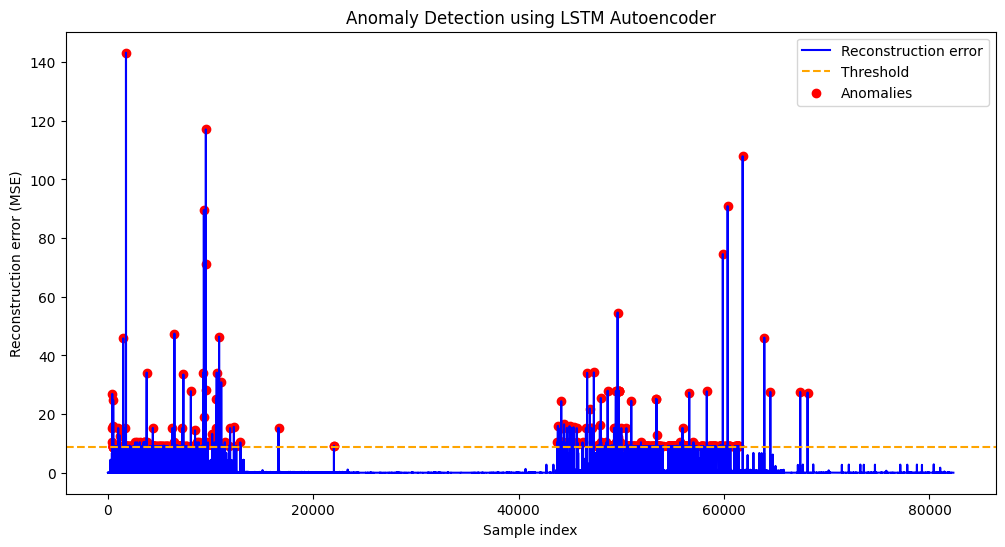

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report


# Load data
train = pd.read_csv("UNSW_NB15_training-set.csv")
test = pd.read_csv("UNSW_NB15_testing-set.csv")

# Separate features and labels
X_train = train.drop(columns=['label'])
y_train = train['label']

X_test = test.drop(columns=['label'])
y_test = test['label']


# Encode categorical features (combine to ensure same columns)
combined = pd.concat([X_train, X_test], axis=0)
combined = pd.get_dummies(combined)

# Align train/test back
X_train = combined.iloc[:len(X_train), :]
X_test = combined.iloc[len(X_train):, :]


# Scale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape to 3D for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# LSTM Autoencoder
model = Sequential([
    LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    RepeatVector(X_train.shape[1]),
    LSTM(64, activation='relu', return_sequences=True),
    TimeDistributed(Dense(X_train.shape[2]))
])

model.compile(optimizer='adam', loss='mse')


# Train only on normal traffic (label=0)
X_train_normal = X_train[y_train == 0]

model.fit(X_train_normal, X_train_normal,
          epochs=10,
          batch_size=32,
          validation_split=0.1,
          shuffle=True)


# Test
X_pred = model.predict(X_test)
mse = np.mean(np.power(X_test - X_pred, 2), axis=(1, 2))

# Pick threshold (tune this later)
threshold = np.percentile(mse, 99)
y_pred = (mse > threshold).astype(int)


# Results
print("Threshold:", threshold)
print(classification_report(y_test, y_pred))


# Plot anomalies
plt.figure(figsize=(12,6))
plt.plot(mse, label="Reconstruction error", color="blue")
plt.axhline(threshold, color='orange', linestyle='--', label="Threshold")

# anomalies as red dots
anomalies = np.where(y_pred == 1)[0]
plt.scatter(anomalies, mse[anomalies], color='red', marker='o', label="Anomalies")

plt.xlabel("Sample index")
plt.ylabel("Reconstruction error (MSE)")
plt.title("Anomaly Detection using LSTM Autoencoder")
plt.legend()
plt.show()

In [32]:
print(X_train);

[[[-1.73204093 -0.19102881 -0.10445581 ... -0.25226905 -0.08064564
   -0.02723899]]

 [[-1.73202117 -0.10948479 -0.04601353 ... -0.25226905 -0.08064564
   -0.02723899]]

 [[-1.73200142  0.04069922 -0.08984524 ... -0.25226905 -0.08064564
   -0.02723899]]

 ...

 [[ 1.73200142 -0.20977336 -0.13367695 ... -0.25226905 -0.08064564
   -0.02723899]]

 [[ 1.73202117 -0.20977336 -0.13367695 ... -0.25226905 -0.08064564
   -0.02723899]]

 [[ 1.73204093 -0.20977336 -0.13367695 ... -0.25226905 -0.08064564
   -0.02723899]]]
